# Summary statistics of coastal change for African countries

* **Products used:** [DE Africa Coastlines]()



## Description

The rate of change points augmented with country (level 0) and province (level 1) labels will be used to generate continental scale statistics.

In [15]:
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import numpy as np
from shapely.ops import nearest_points

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.coastal import get_coastlines
#from deafrica_tools.plotting import display_map
from datacube.utils.geometry import Geometry
from coastlines.vector import change_regress

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


## Load augmented rate of change

Only `good` rate of change measurements have been kept.
Admin boundary labels have been matched with the following code.

```
gadm_africa  = gpd.read_file("~/dev/data/gadm_africa.gpkg")
gadm_level1 = gadm_africa.dissolve(by=f"GID_1")
gadm_level1 = gadm_level1.to_crs(coastlines.crs)
gadm_level1.reset_index(inplace=True)

# match coastlines to admin region geometries
coastlines = coastlines.sjoin_nearest(gadm_level1[["GID_0", "NAME_0", "GID_1", "NAME_1","geometry"]], how="left", max_distance=1000, distance_col="GID_1_dist")
coastlines = coastlines.drop(columns=["index_right"])

```

In [2]:
%%time
coastlines = gpd.read_file("~/dev/data/deafricacoastlines_v0.4.0_nearest_gadm_level1.gpkg")

CPU times: user 17min 43s, sys: 10.2 s, total: 17min 53s
Wall time: 18min 46s


In [3]:
coastlines.head()

,index,uid,rate_time,sig_time,se_time,outl_time,dist_2000,dist_2001,dist_2002,dist_2003,...,nsm,max_year,min_year,country,certainty,GID_0,NAME_0,GID_1,NAME_1,geometry
0,0,sv0e5jprxn,-0.19,0.004,0.06,2016 2018 2019,3.11,1.34,1.79,1.55,...,-3.11,2000,2010,Egypt,good,EGY,Egypt,EGY.22_1,Janub Sina',POINT (3337964.536 3511650.480)
1,1,sv0e5jr8u3,-0.33,0.013,0.12,2019,3.08,0.94,1.69,0.74,...,-3.08,2000,2018,Egypt,good,EGY,Egypt,EGY.22_1,Janub Sina',POINT (3337985.922 3511671.507)
2,2,sv0e5jrcce,-0.30,0.105,0.17,None,2.46,-0.39,0.97,-0.46,...,-2.46,2000,2019,Egypt,good,EGY,Egypt,EGY.22_1,Janub Sina',POINT (3338007.608 3511692.203)
3,3,sv0e5jrfyy,-0.04,0.444,0.05,None,2.33,0.27,0.25,-0.92,...,-2.33,2000,2010,Egypt,good,EGY,Egypt,EGY.22_1,Janub Sina',POINT (3338029.177 3511713.014)
4,4,sv0e5m2h5c,-0.04,0.282,0.04,None,2.55,1.20,0.71,0.26,...,-2.55,2000,2010,Egypt,good,EGY,Egypt,EGY.22_1,Janub Sina',POINT (3338050.593 3511734.009)


In [54]:
%%time

def calculate_regressions(points_gdf, x_years):
    """
    For each rate of change point along the baseline annual coastline,
    compute linear regression rates of change against both time and
    climate indices.

    Regressions are computed after removing outliers to ensure robust
    results.

    Parameters:
    -----------
    points_gdf : geopandas.GeoDataFrame
        A `geopandas.GeoDataFrame` containing rates of change points
        with 'dist_*' annual movement/distance data.
    x_years : list of integer years

    Returns:
    --------
    points_gdf : geopandas.GeoDataFrame
        A `geopandas.GeoDataFrame` containing rates of change points
        with additional attribute columns:

            'rate_*':  Slope of the regression
            'sig_*':   Significance of the regression
            'se_*':    Standard error of the  regression
            'outl_*':  A list of any outlier years excluded from the
                       regression
    """

    # Restrict climate and points data to years in datasets
    dist_years = [f"dist_{i}" for i in x_years]
    points_subset = points_gdf[dist_years]

    # Compute coastal change rates by linearly regressing annual
    # movements vs. time
    rate_out = points_subset.apply(
        lambda row: change_regress(
            y_vals=row.values.astype(float), x_vals=x_years, x_labels=x_years
        ),
        axis=1,
    )
    points_gdf[
        ["rate_time", "incpt_time", "sig_time", "se_time", "outl_time"]
    ] = rate_out

    # Copy slope and intercept into points_subset so they can be
    # used to temporally de-trend annual distances
    points_subset[["slope", "intercept"]] = rate_out[["slope", "intercept"]]

    # Custom sorting
    reg_cols = ["rate_time", "sig_time", "se_time", "outl_time"]

    return points_gdf.loc[
        :, [*reg_cols, *dist_years, "angle_mean", "angle_std", "geometry"]
    ]


recent_years = np.arange(2016,2022)
# Calculate rates of change using linear regression
points_gdf = calculate_regressions(coastlines.copy(), recent_years)

CPU times: user 19min 26s, sys: 3.01 s, total: 19min 29s
Wall time: 19min 30s


In [55]:
points_gdf.head()

,rate_time,sig_time,se_time,outl_time,dist_2016,dist_2017,dist_2018,dist_2019,dist_2020,dist_2021,angle_mean,angle_std,geometry
0,6.075,0.302,5.136,,-42.34,-3.28,-42.81,-43.12,-2.87,0.0,136,25,POINT (3337964.536 3511650.480)
1,2.059,0.176,1.168,2019,-12.35,-3.21,-12.81,-55.47,-2.40,0.0,136,25,POINT (3337985.922 3511671.507)
2,0.298,0.469,0.360,2019,-0.88,-3.67,-0.45,-25.48,-1.44,0.0,139,15,POINT (3338007.608 3511692.203)
3,0.399,0.186,0.250,,-0.83,-3.15,-0.57,-0.75,0.18,0.0,140,8,POINT (3338029.177 3511713.014)
4,-0.186,0.359,0.180,,1.08,-0.75,0.60,-0.46,-0.77,0.0,140,8,POINT (3338050.593 3511734.009)


In [67]:
coastlines = coastlines.join(points_gdf[["rate_time", "sig_time", "se_time", "outl_time"]],
                rsuffix=f'_{recent_years[0]}_{recent_years[-1]}')

In [77]:
# Probability of recent rate larger than rate+se ~ (0.5-0.341)
# Probability of all time rate smaller than rate-se ~ 0.5-0.341

0.7072809999999999

## Summarize change for each country

In [105]:
countries = coastlines.NAME_0.unique()
countries = [c for c in countries if str(c)!='nan' and (c!='Spain')]

In [196]:
countries_summary = pd.DataFrame(countries, columns=["Country"])
countries_summary[['perc_neg05', 'perc_no', 'perc_pos05', 'km_neg05', 'km_no', 'km_pos05']] = [np.nan]*6
countries_summary[['perc_negsm10', 'perc_nosm', 'perc_possm10', 'km_negsm10', 'km_nosm', 'km_possm10']] = [np.nan]*6
countries_summary[['perc_negsm5_2000_2011', 'perc_possm5_2000_2011', 'perc_negsm5_2010_2021', 'perc_possm5_2010_2021']] = [np.nan]*4
countries_summary[['perc_neg05_acc', 'km_neg05_acc']] = [np.nan]*2

In [237]:
for idx in countries_summary.index:
    good_rates = coastlines[coastlines[f"NAME_0"]==countries_summary.loc[idx][f"Country"]]
    if len(good_rates)==0:
        print("no data over", countries_summary.loc[idx][f"Country"])
        continue

    # get stats
    total = len(good_rates)
    perc_neg05 = ((good_rates.sig_time<0.01) & (good_rates.rate_time<-0.5)).sum()*100/total
    perc_pos05 = ((good_rates.sig_time<0.01) & (good_rates.rate_time>0.5)).sum()*100/total
    perc_no = 100. - perc_neg05 - perc_pos05
    perc_negsm10 = (good_rates.nsm<-10).sum()*100/total
    perc_possm10 = (good_rates.nsm>10).sum()*100/total
    perc_nosm = 100. - perc_negsm10 - perc_possm10
    
    change_2000_2011 = good_rates.dist_2011-good_rates.dist_2000
    change_2010_2021 = good_rates.dist_2021-good_rates.dist_2010
    perc_negsm5_2000_2011 = ((good_rates.sig_time<0.01) & (change_2000_2011<-5)).sum()*100/total
    perc_possm5_2000_2011 = ((good_rates.sig_time<0.01) & (change_2000_2011>5)).sum()*100/total
    perc_negsm5_2010_2021 = ((good_rates.sig_time<0.01) &(change_2010_2021<-5)).sum()*100/total
    perc_possm5_2010_2021 = ((good_rates.sig_time<0.01) &(change_2010_2021>5)).sum()*100/total
  
    total_km = total*30/1000
    km_neg05 = ((good_rates.sig_time<0.01) & (good_rates.rate_time<-0.5)).sum()*30/1000
    km_pos05 = ((good_rates.sig_time<0.01) & (good_rates.rate_time>0.5)).sum()*30/1000
    km_no = total_km - km_neg05 - km_pos05
    km_negsm10 = (good_rates.nsm<-10).sum()*30/1000
    km_possm10 = (good_rates.nsm>10).sum()*30/1000
    km_nosm = total_km - km_negsm10 - km_possm10

    for cname in ['perc_neg05', 'perc_no', 'perc_pos05', 'km_neg05', 'km_no', 'km_pos05']:
        countries_summary.at[idx, cname] = eval(cname)
    
    for cname in ['perc_negsm10', 'perc_nosm', 'perc_possm10', 'km_negsm10', 'km_nosm', 'km_possm10']:
        countries_summary.at[idx, cname] = eval(cname)
    
    for cname in ['perc_negsm5_2000_2011', 'perc_possm5_2000_2011', 'perc_negsm5_2010_2021', 'perc_possm5_2010_2021']:
        countries_summary.at[idx, cname] = eval(cname)
    
    # 1.96* - retreating faster at higher than 99% confidence (only 0.025*0.025 probability to overlap)
    # 1* - retreating faster at higher than 97% confidence (only 0.16*0.16 probability to overlap)
    neg05_acc = (good_rates.sig_time<0.01) & (good_rates.rate_time<-0.5) & (
        (good_rates[f'rate_time_{recent_years[0]}_{recent_years[-1]}']+good_rates[f'se_time_{recent_years[0]}_{recent_years[-1]}'])
        < (good_rates.rate_time-good_rates.se_time)
    ) & (good_rates[f'sig_time_{recent_years[0]}_{recent_years[-1]}']<0.01)
    countries_summary.at[idx, "perc_neg05_acc"] = neg05_acc.sum()*100/len(good_rates)
    countries_summary.at[idx, "km_neg05_acc"] = neg05_acc.sum()*30/1000

In [238]:
countries_summary.head()

,Country,perc_neg05,perc_no,perc_pos05,km_neg05,km_no,km_pos05,perc_negsm10,perc_nosm,perc_possm10,km_negsm10,km_nosm,km_possm10,perc_negsm5_2000_2011,perc_possm5_2000_2011,perc_negsm5_2010_2021,perc_possm5_2010_2021,perc_neg05_acc,km_neg05_acc
0,Djibouti,4.742027,74.302889,20.955084,17.04,267.00,75.30,9.575889,69.385540,21.038571,34.41,249.33,75.60,5.485056,19.978294,7.012857,18.817833,1.110369,3.99
1,Cameroon,12.873306,57.258226,29.868468,96.60,429.66,224.13,10.450566,67.181066,22.368368,78.42,504.12,167.85,3.458202,17.726782,15.647863,17.842722,3.102387,23.28
2,Tanzania,6.626944,68.344908,25.028148,199.53,2057.79,753.57,11.771270,61.307454,26.921276,354.42,1845.90,810.57,8.006935,16.566862,6.979664,22.179488,0.958521,28.86
3,Somalia,7.919178,80.520296,11.560525,260.91,2652.87,380.88,12.954599,72.180437,14.864963,426.81,2378.10,489.75,7.887309,12.674145,8.918067,9.651072,0.662891,21.84
4,Kenya,8.439386,72.884884,18.675731,96.09,829.86,212.64,13.266408,64.983005,21.750586,151.05,739.89,247.65,10.916133,10.723790,7.672648,19.260665,0.972255,11.07


## Plot as stacked bar charts

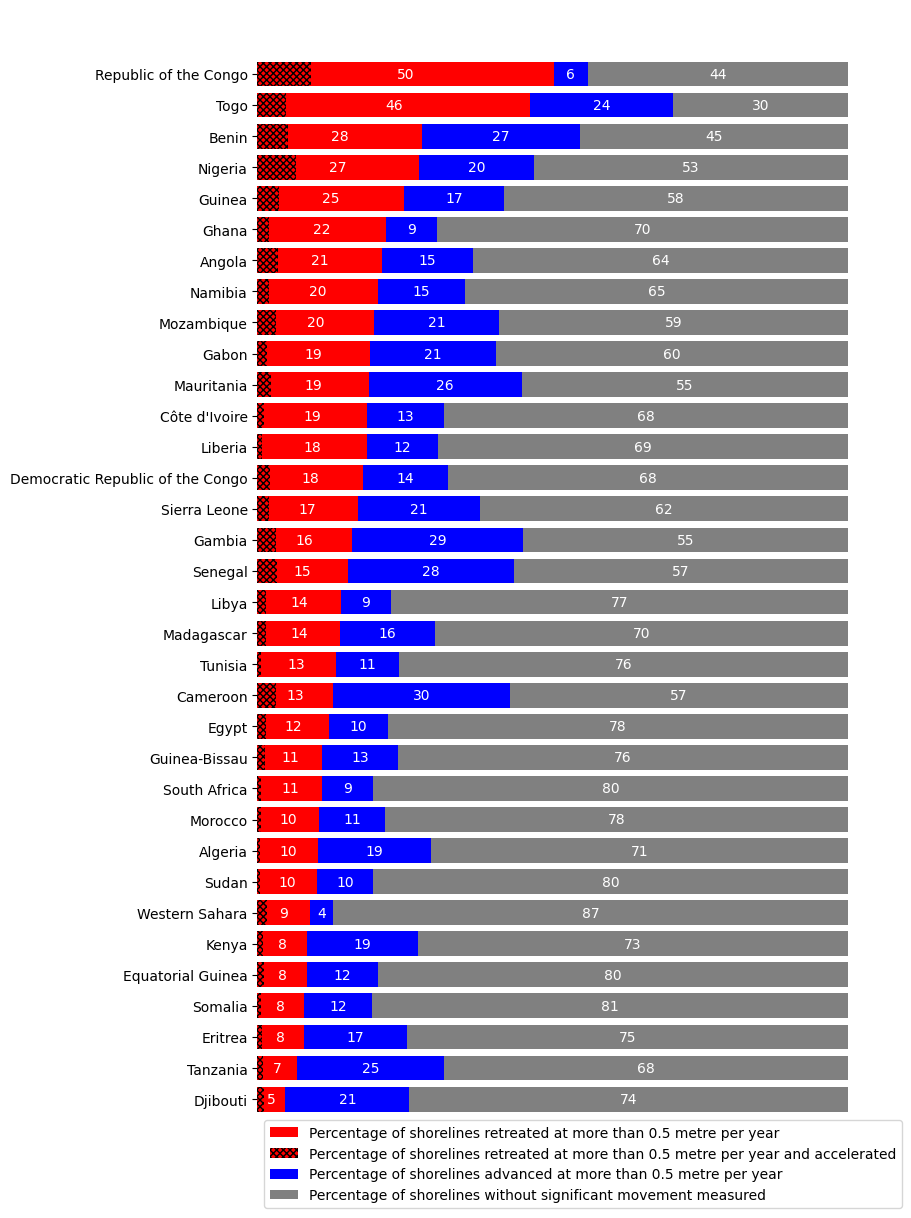

In [246]:
countries_sorted = countries_summary.sort_values(by='perc_neg05')

countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.perc_neg05)
pos_data = list(countries_sorted.perc_pos05)
no_data = list(countries_sorted.perc_no)
acc_data = list(countries_sorted.perc_neg05_acc)
# Set the color scheme for the segments
colors = ['red', 'blue', 'grey']

# Create a list of indices for the bars
indices = np.arange(len(countries))

fig, ax = plt.subplots(figsize=(8,15))

# Plot the stacked horizontal bars
neg_bars = ax.barh(indices, neg_data, color=colors[0], label='Percentage of shorelines retreated at more than 0.5 metre per year')
acc_bars = ax.barh(indices, acc_data, color=colors[0], hatch = 'xxxxx', label='Percentage of shorelines retreated at more than 0.5 metre per year and accelerated')
pos_bars = ax.barh(indices, pos_data, left=neg_data, color=colors[1], label='Percentage of shorelines advanced at more than 0.5 metre per year')
no_bars = ax.barh(indices, no_data, left=np.add(neg_data, pos_data), color=colors[2], label='Percentage of shorelines without significant movement measured')

# Remove spines and ticks
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add data value text to the center of each colored bar segment
for bars in [neg_bars, pos_bars, no_bars]:
    for bar in bars:
        width = bar.get_width()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + bar.get_height() / 2
        ax.text(x_center, y_center, str(round(width)), ha='center', va='center', color='white')

# Set the y-axis ticks and labels
ax.set_yticks(indices)
ax.set_yticklabels(countries)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0, 0), ncol=1)

fig.savefig('countries_rate_perc.png', bbox_inches='tight')

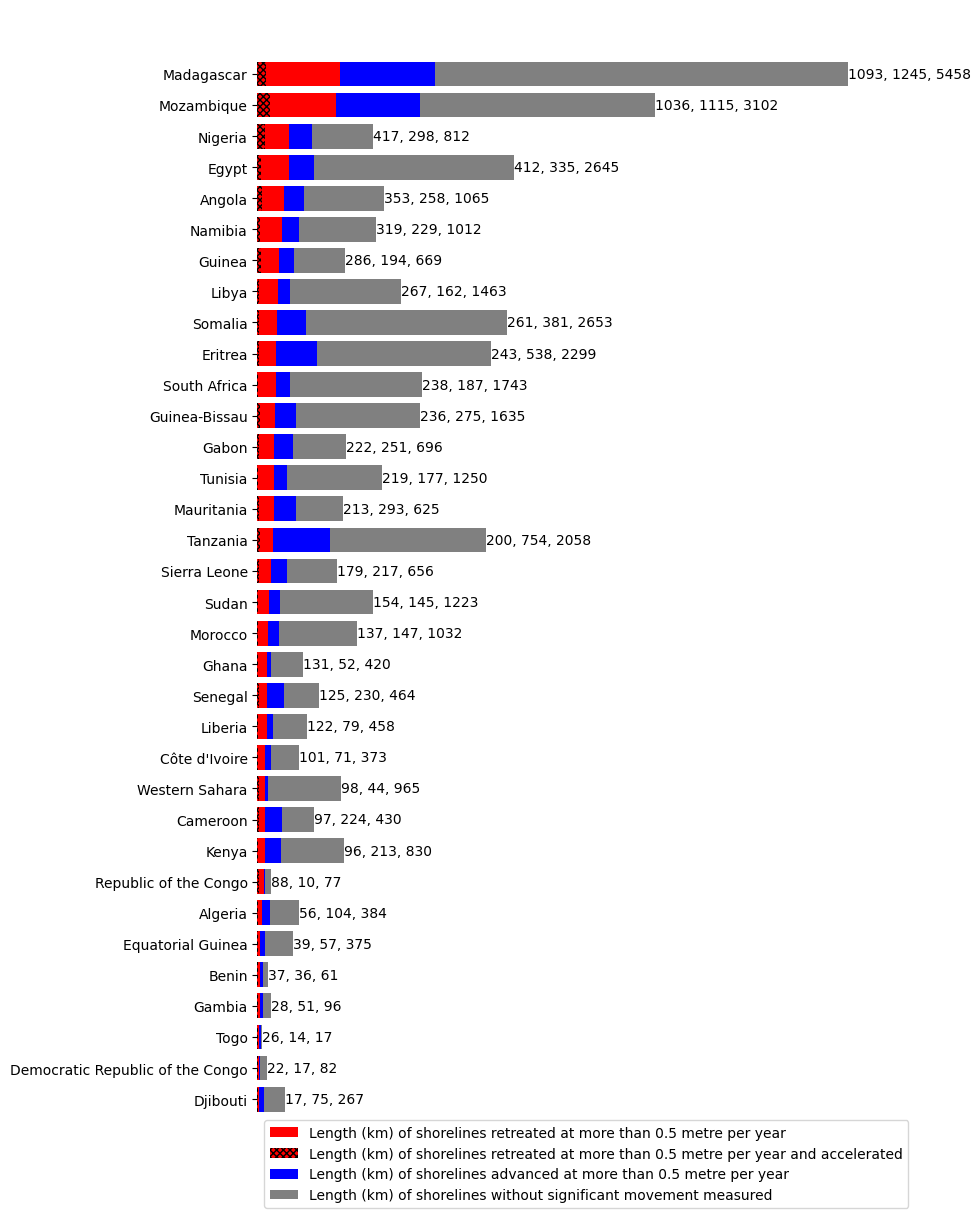

In [240]:
countries_sorted = countries_summary.sort_values(by='km_neg05')

countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.km_neg05)
pos_data = list(countries_sorted.km_pos05)
no_data = list(countries_sorted.km_no)
acc_data = list(countries_sorted.km_neg05_acc)

# Set the color scheme for the segments
colors = ['red', 'blue', 'grey']

# Create a list of indices for the bars
indices = np.arange(len(countries))

fig, ax = plt.subplots(figsize=(8,15))

# Plot the stacked horizontal bars
neg_bars = ax.barh(indices, neg_data, color=colors[0], label='Length (km) of shorelines retreated at more than 0.5 metre per year')
acc_bars = ax.barh(indices, acc_data, color=colors[0], hatch = 'xxxxx', label='Length (km) of shorelines retreated at more than 0.5 metre per year and accelerated')
pos_bars = ax.barh(indices, pos_data, left=neg_data, color=colors[1], label='Length (km) of shorelines advanced at more than 0.5 metre per year')
no_bars = ax.barh(indices, no_data, left=np.add(neg_data, pos_data), color=colors[2], label='Length (km) of shorelines without significant movement measured')

# Remove spines and ticks
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add data value text to the center of each bar segment
for i in range(len(countries)):
    total_width = neg_data[i] + pos_data[i] + no_data[i]
    x_center = total_width
    y_center = indices[i]
    ax.text(x_center, y_center, f"{round(neg_data[i])}, {round(pos_data[i])}, {round(no_data[i])}", ha='left', va='center')

# Set the y-axis ticks and labels
ax.set_yticks(indices)
ax.set_yticklabels(countries)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0, 0), ncol=1)

fig.savefig('countries_rate_km.png',bbox_inches='tight')

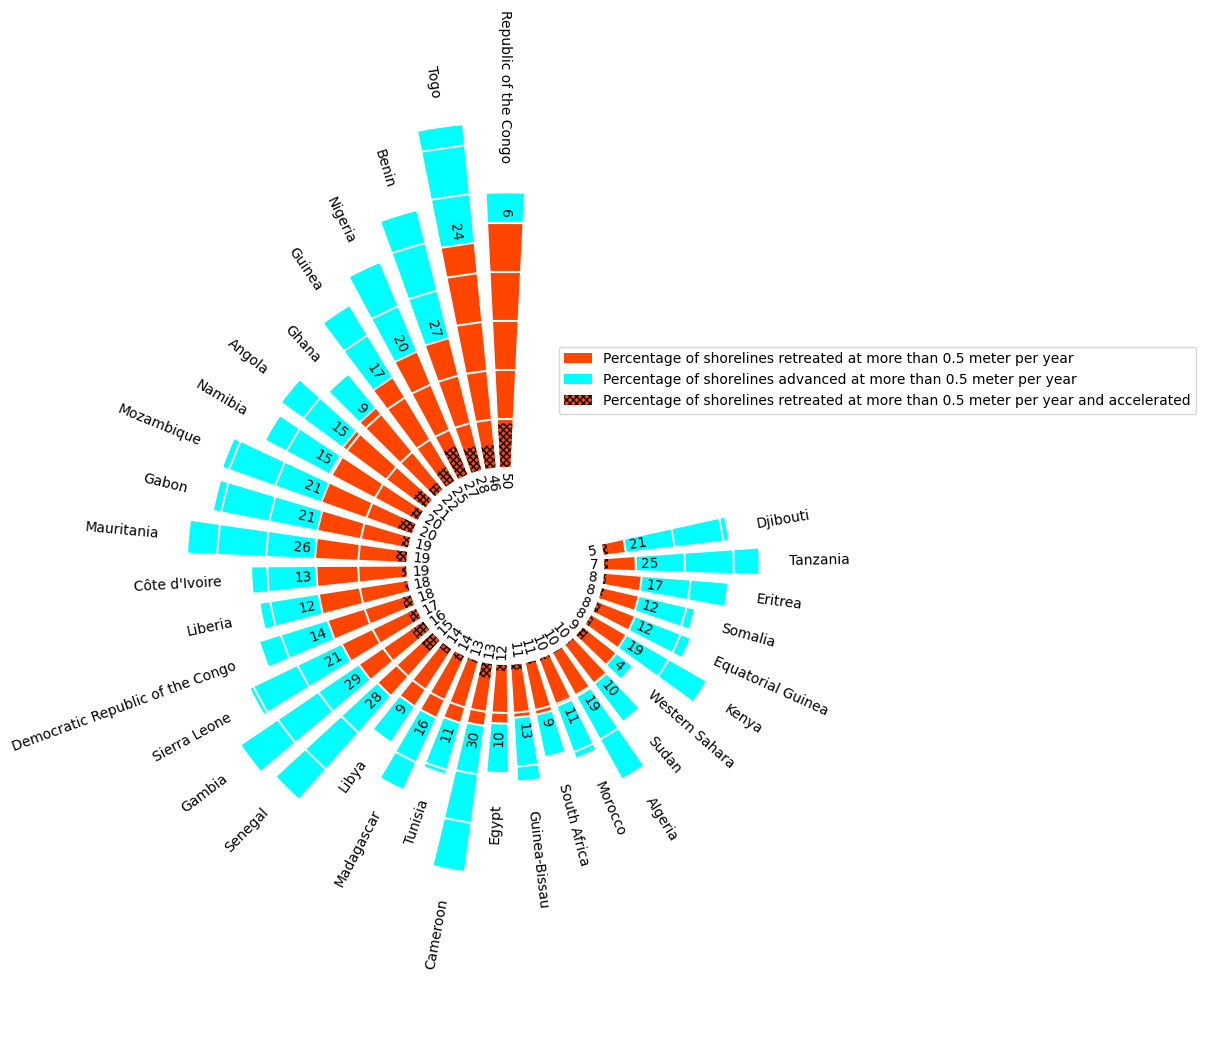

In [248]:
countries_sorted = countries_summary.sort_values(by='perc_neg05', ascending=False)


countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.perc_neg05)
pos_data = list(countries_sorted.perc_pos05)
acc_data = list(countries_sorted.perc_neg05_acc)

# Set the color scheme for the segments
colors = ['orangered', 'cyan', 'grey']

# Calculate the angle for each bar
angles = np.linspace(0, 1.6*np.pi, len(countries), endpoint=False)

# Create a polar plot
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, polar=True)

base= 20 #[np.max(neg_data)/2]*len(neg_data)
w=0.1
# Plot the red segments
ax.bar(angles, base, width=w, color='white')
neg_bars = ax.bar(angles, neg_data, width=w, bottom=base, color=colors[0], label='Percentage of shorelines retreated at more than 0.5 meter per year')
# Plot the white segments on top of the red segments
pos_bars = ax.bar(angles, pos_data, width=w, bottom=np.add(base, neg_data), color=colors[1], label='Percentage of shorelines advanced at more than 0.5 meter per year')
# Plot the blue segments on top of the red and white segments
#ax.bar(angles, blue_data, width=0.5, bottom=np.add(red_data, white_data), color=colors[2], label='Blue')
acc_bars = ax.bar(angles, acc_data, width=w, bottom=base, color=colors[0], hatch='xxxxx', label='Percentage of shorelines retreated at more than 0.5 meter per year and accelerated')

# Set the starting angle at the top (North)
ax.set_theta_zero_location("N")

# Set the clockwise direction for the bars
ax.set_theta_direction(1)

# Set the tick labels
ax.set_xticks([])

ax.set_yticks([])
ax.axis("off")
# Set the radial grid lines every 10 percent
#ax.set_yticks(np.arange(0, 101, 10))
#ax.yaxis.grid(color='white', linewidth=2)

# Remove the radial tick labels
ax.set_yticklabels([])
# Remove the outer frame (circle)
ax.spines['polar'].set_visible(False)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0.55, 0.7), ncol=1)

# Add country labels radially
for angle, country, label_radius in zip(angles, countries, np.add(np.add(np.add(neg_data, pos_data), base), np.max(neg_data)/8)):
    if angle<np.pi: rot, ha = 270, 'right'
    else: rot, ha = 90, 'left'
    ax.text(angle, label_radius, country, ha=ha, va='center', fontsize=10,
            rotation=rot,#np.degrees(angle), 
            rotation_mode='anchor', transform_rotates_text=True)

# Add data value text to the center of each colored bar segment
for bars in [neg_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() -1 #+ bar.get_height() / 2
        if x_center<np.pi: rot, ha = 270, 'left'
        else: rot, ha = 90, 'right'
        ax.text(x_center, y_center, str(round(h)), ha=ha, va='center', fontsize=10, 
                color='black', rotation=rot, rotation_mode='anchor', transform_rotates_text=True)
        for y in np.arange(bar.get_y(), bar.get_y()+bar.get_height(), 10):
            ax.plot([x_center-bar.get_width() / 2, x_center+bar.get_width() / 2], 
                    [y, y], color='white')
for bars in [pos_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + 1#+ bar.get_height() / 2
        if x_center<np.pi: rot, ha = 270, 'right'
        else: rot, ha = 90, 'left'
        ax.text(x_center, y_center, str(round(h)), ha=ha, va='center', fontsize=10, 
                color='black', rotation=rot, rotation_mode='anchor', transform_rotates_text=True)
        for y in np.arange(bar.get_y(), bar.get_y()+bar.get_height(), 10):
            ax.plot([x_center-bar.get_width() / 2, x_center+bar.get_width() / 2], 
                    [y, y], color='white')
        
        
fig.savefig('countries_rate_perc_polar_270_withnumbers.png',bbox_inches='tight')
#fig.savefig('countries_rate_perc_polar_270_nonumbers.png',bbox_inches='tight')

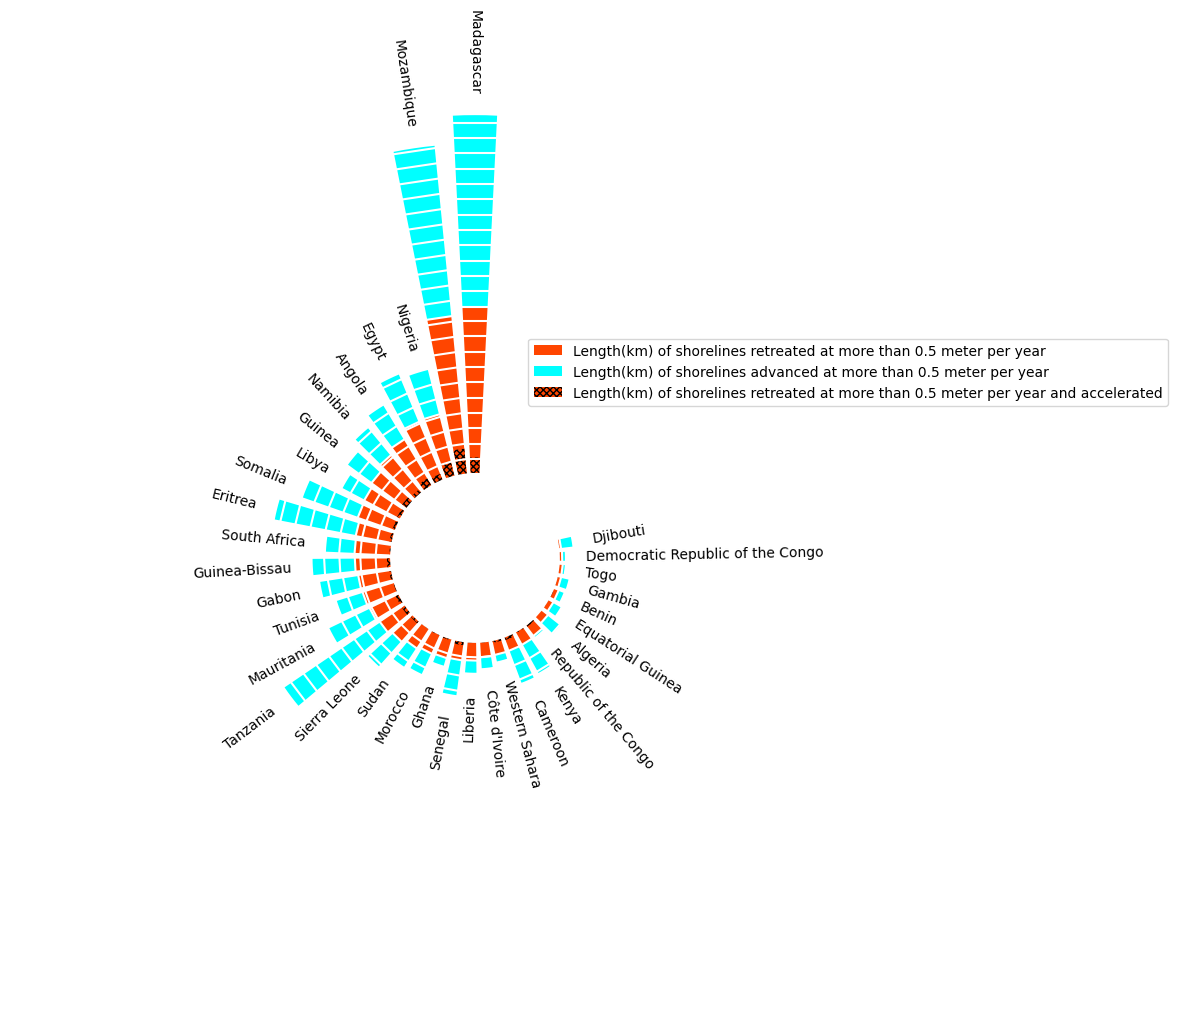

In [242]:
countries_sorted = countries_summary.sort_values(by='km_neg05', ascending=False)

countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.km_neg05)
pos_data = list(countries_sorted.km_pos05)
acc_data = list(countries_sorted.km_neg05_acc)

# Set the color scheme for the segments
colors = ['orangered', 'cyan', 'grey']

# Calculate the angle for each bar
angles = np.linspace(0, 1.6*np.pi, len(countries), endpoint=False)

# Create a polar plot
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, polar=True)

base= [np.max(neg_data)/2]*len(neg_data)
w=0.1
# Plot the red segments
ax.bar(angles, base, width=w, color='white')
neg_bars = ax.bar(angles, neg_data, width=w, bottom=base, color=colors[0], label='Length(km) of shorelines retreated at more than 0.5 meter per year')
# Plot the white segments on top of the red segments
pos_bars = ax.bar(angles, pos_data, width=w, bottom=np.add(base, neg_data), color=colors[1], label='Length(km) of shorelines advanced at more than 0.5 meter per year')
# Plot the blue segments on top of the red and white segments
#ax.bar(angles, blue_data, width=0.5, bottom=np.add(red_data, white_data), color=colors[2], label='Blue')
acc_bars = ax.bar(angles, acc_data, width=w, bottom=base, color=colors[0], hatch='xxxxx', label='Length(km) of shorelines retreated at more than 0.5 meter per year and accelerated')

# Set the starting angle at the top (North)
ax.set_theta_zero_location("N")

# Set the clockwise direction for the bars
ax.set_theta_direction(1)

# Set the tick labels
ax.set_xticks([])

ax.set_yticks([])
ax.axis("off")
# Set the radial grid lines every 10 percent
#ax.set_yticks(np.arange(0, 101, 10))
#ax.yaxis.grid(color='white', linewidth=2)

# Remove the radial tick labels
ax.set_yticklabels([])
# Remove the outer frame (circle)
ax.spines['polar'].set_visible(False)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0.55, 0.7), ncol=1)

# Add country labels radially
for angle, country, label_radius in zip(angles, countries, np.add(np.add(np.add(neg_data, pos_data), base), np.max(neg_data)/8)):
    if angle<np.pi: rot, ha = 270, 'right'
    else: rot, ha = 90, 'left'
    ax.text(angle, label_radius, country, ha=ha, va='center', fontsize=10,
            rotation=rot,#np.degrees(angle), 
            rotation_mode='anchor', transform_rotates_text=True)

# Add data value text to the center of each colored bar segment
for bars in [neg_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() -1 #+ bar.get_height() / 2
        if x_center<np.pi: rot, ha = 270, 'left'
        else: rot, ha = 90, 'right'
        #ax.text(x_center, y_center, str(round(h)), ha=ha, va='center', fontsize=10, 
        #        color='black', rotation=rot, rotation_mode='anchor', transform_rotates_text=True)
        for y in np.arange(bar.get_y(), bar.get_y()+bar.get_height(), 100):
            ax.plot([x_center-bar.get_width() / 2, x_center+bar.get_width() / 2], 
                    [y, y], color='white')
for bars in [pos_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + 1#+ bar.get_height() / 2
        if x_center<np.pi: rot, ha = 270, 'right'
        else: rot, ha = 90, 'left'
        #ax.text(x_center, y_center, str(round(h)), ha=ha, va='center', fontsize=10, 
        #        color='black', rotation=rot, rotation_mode='anchor', transform_rotates_text=True)
        for y in np.arange(bar.get_y(), bar.get_y()+bar.get_height(), 100):
            ax.plot([x_center-bar.get_width() / 2, x_center+bar.get_width() / 2], 
                    [y, y], color='white')
        
        
fig.savefig('countries_rate_km_polar_270_withnumbers.png',bbox_inches='tight')
#fig.savefig('countries_rate_km_polar_270_nonumbers.png',bbox_inches='tight')

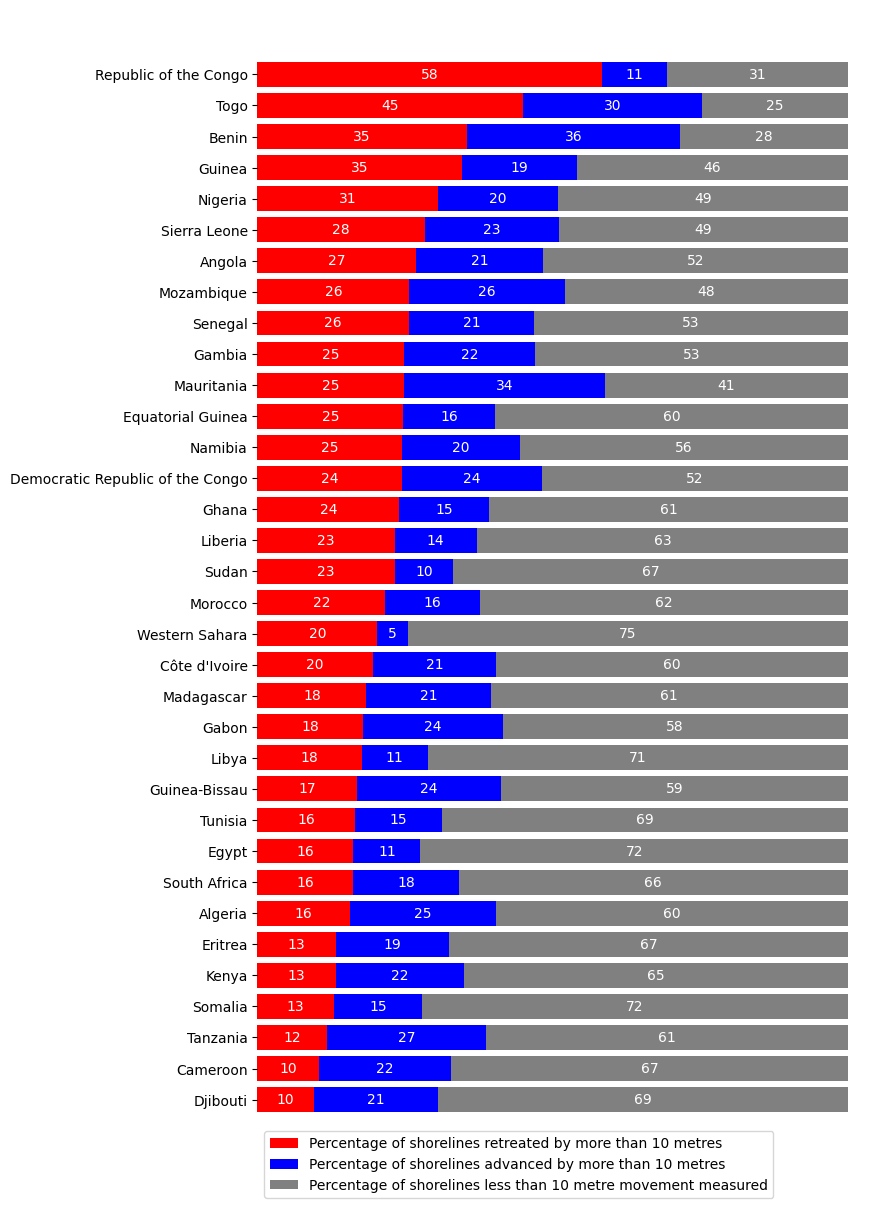

In [232]:
countries_sorted = countries_summary.sort_values(by='perc_negsm10')

countries = list(countries_sorted.Country)
red_data = list(countries_sorted.perc_negsm10)
white_data = list(countries_sorted.perc_possm10)
blue_data = list(countries_sorted.perc_nosm)

# Set the color scheme for the segments
colors = ['red', 'blue', 'grey']

# Create a list of indices for the bars
indices = np.arange(len(countries))

fig, ax = plt.subplots(figsize=(8,15))

# Plot the stacked horizontal bars
red_bars = ax.barh(indices, red_data, color=colors[0], label='Percentage of shorelines retreated by more than 10 metres')
white_bars = ax.barh(indices, white_data, left=red_data, color=colors[1], label='Percentage of shorelines advanced by more than 10 metres')
blue_bars = ax.barh(indices, blue_data, left=np.add(red_data, white_data), color=colors[2], label='Percentage of shorelines less than 10 metre movement measured')

# Remove spines and ticks
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add data value text to the center of each colored bar segment
for bars in [red_bars, white_bars, blue_bars]:
    for bar in bars:
        width = bar.get_width()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + bar.get_height() / 2
        ax.text(x_center, y_center, str(round(width)), ha='center', va='center', color='white')

# Set the y-axis ticks and labels
ax.set_yticks(indices)
ax.set_yticklabels(countries)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0, 0), ncol=1)

fig.savefig('countries_sm_perc.png', bbox_inches='tight')

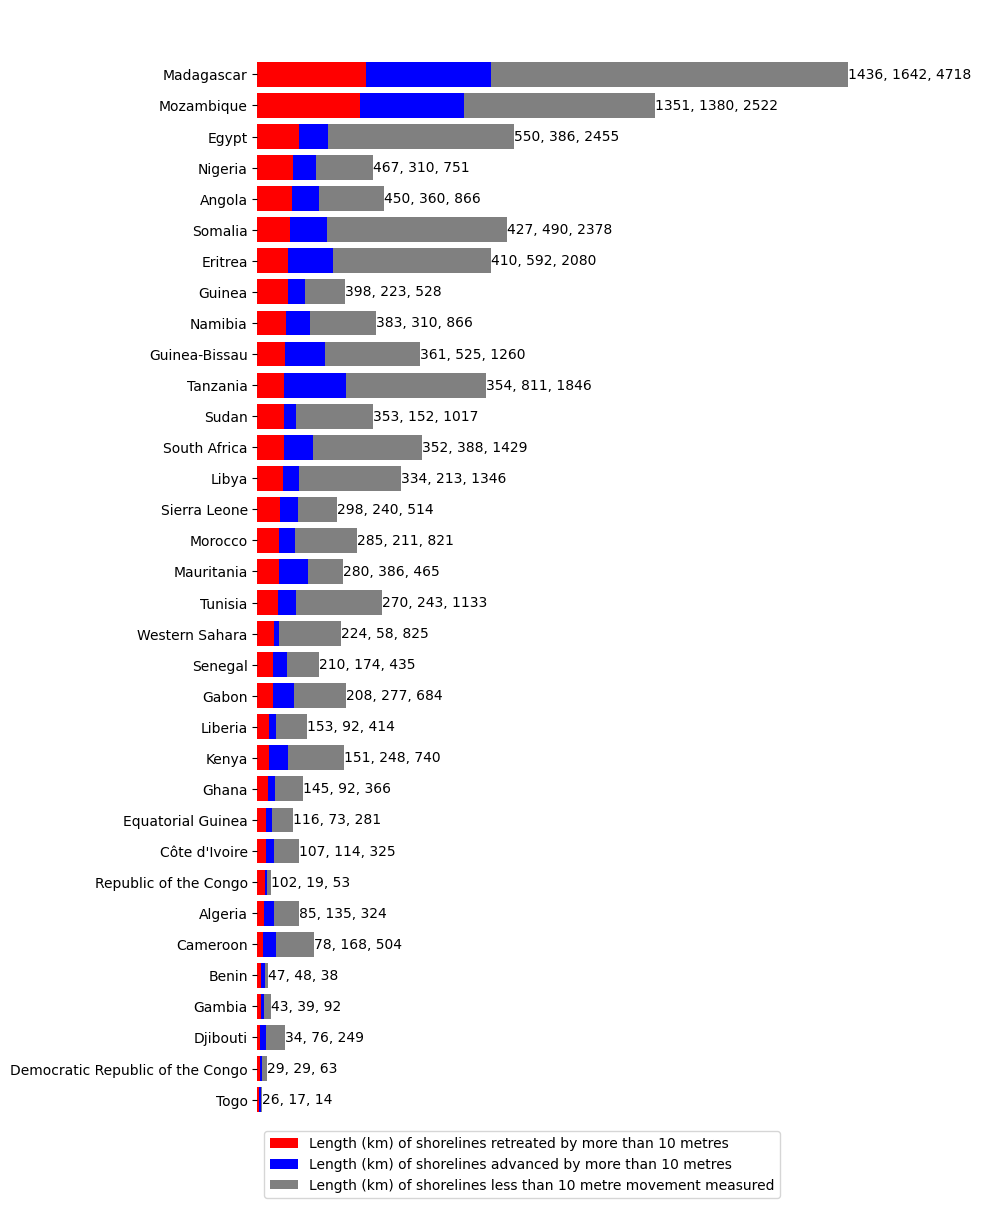

In [233]:
countries_sorted = countries_summary.sort_values(by='km_negsm10')

countries = list(countries_sorted.Country)
red_data = list(countries_sorted.km_negsm10)
white_data = list(countries_sorted.km_possm10)
blue_data = list(countries_sorted.km_nosm)

# Set the color scheme for the segments
colors = ['red', 'blue', 'grey']

# Create a list of indices for the bars
indices = np.arange(len(countries))

fig, ax = plt.subplots(figsize=(8,15))

# Plot the stacked horizontal bars
red_bars = ax.barh(indices, red_data, color=colors[0], label='Length (km) of shorelines retreated by more than 10 metres')
white_bars = ax.barh(indices, white_data, left=red_data, color=colors[1], label='Length (km) of shorelines advanced by more than 10 metres')
blue_bars = ax.barh(indices, blue_data, left=np.add(red_data, white_data), color=colors[2], label='Length (km) of shorelines less than 10 metre movement measured')

# Remove spines and ticks
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add data value text to the center of each bar segment
for i in range(len(countries)):
    total_width = red_data[i] + white_data[i] + blue_data[i]
    x_center = total_width
    y_center = indices[i]
    ax.text(x_center, y_center, f"{round(red_data[i])}, {round(white_data[i])}, {round(blue_data[i])}", ha='left', va='center')

# Set the y-axis ticks and labels
ax.set_yticks(indices)
ax.set_yticklabels(countries)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0, 0), ncol=1)

fig.savefig('countries_sm_km.png',bbox_inches='tight')

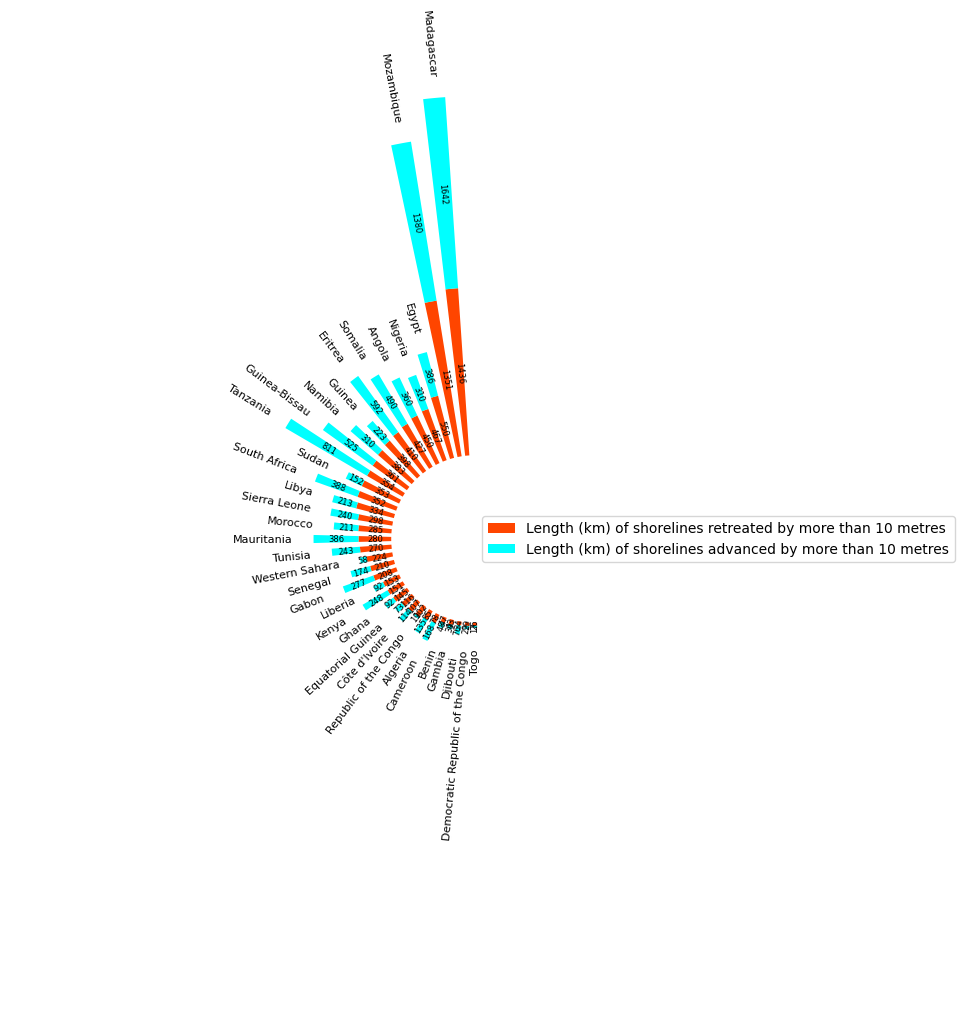

In [84]:
countries_sorted = countries_summary.sort_values(by='km_negsm10')

countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.km_negsm10)
pos_data = list(countries_sorted.km_possm10)
non_data = list(countries_sorted.km_nosm)

# Set the color scheme for the segments
colors = ['orangered', 'cyan', 'grey']

# Calculate the angle for each bar
angles = np.linspace(0, np.pi, len(countries), endpoint=False)

# Create a polar plot
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, polar=True)

base=[np.max(neg_data)/2]*len(neg_data)
w=0.05
# Plot the red segments
ax.bar(angles, base, width=w, color='white')
neg_bars=ax.bar(angles, neg_data, width=w, bottom=base, color=colors[0], label='Length (km) of shorelines retreated by more than 10 metres')
# Plot the white segments on top of the red segments
pos_bars=ax.bar(angles, pos_data, width=w, bottom=np.add(base, neg_data), color=colors[1], label='Length (km) of shorelines advanced by more than 10 metres')
# Plot the blue segments on top of the red and white segments
#ax.bar(angles, blue_data, width=0.5, bottom=np.add(red_data, white_data), color=colors[2], label='Blue')

# Set the starting angle at the top (North)
ax.set_theta_zero_location("S")

# Set the clockwise direction for the bars
ax.set_theta_direction(-1)

# Set the tick labels
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0.5, 0.5), ncol=1)

# Add country labels radially
for angle, country, label_radius in zip(angles, countries, np.add(np.add(np.add(neg_data, pos_data), base), np.max(neg_data)/8)):
    ax.text(angle, label_radius, country, ha='right', va='center', fontsize=8,
            rotation=270,#np.degrees(angle), 
            rotation_mode='anchor', transform_rotates_text=True)

# Add data value text to the center of each colored bar segment
for bars in [neg_bars, pos_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + bar.get_height() / 2
        ax.text(x_center, y_center, str(round(h)), ha='center', va='center', fontsize=6, 
                color='black', rotation=270, rotation_mode='anchor', transform_rotates_text=True)

# Remove gridlines
ax.grid(True)

fig.savefig('countries_sm_km_polar.png',bbox_inches='tight')

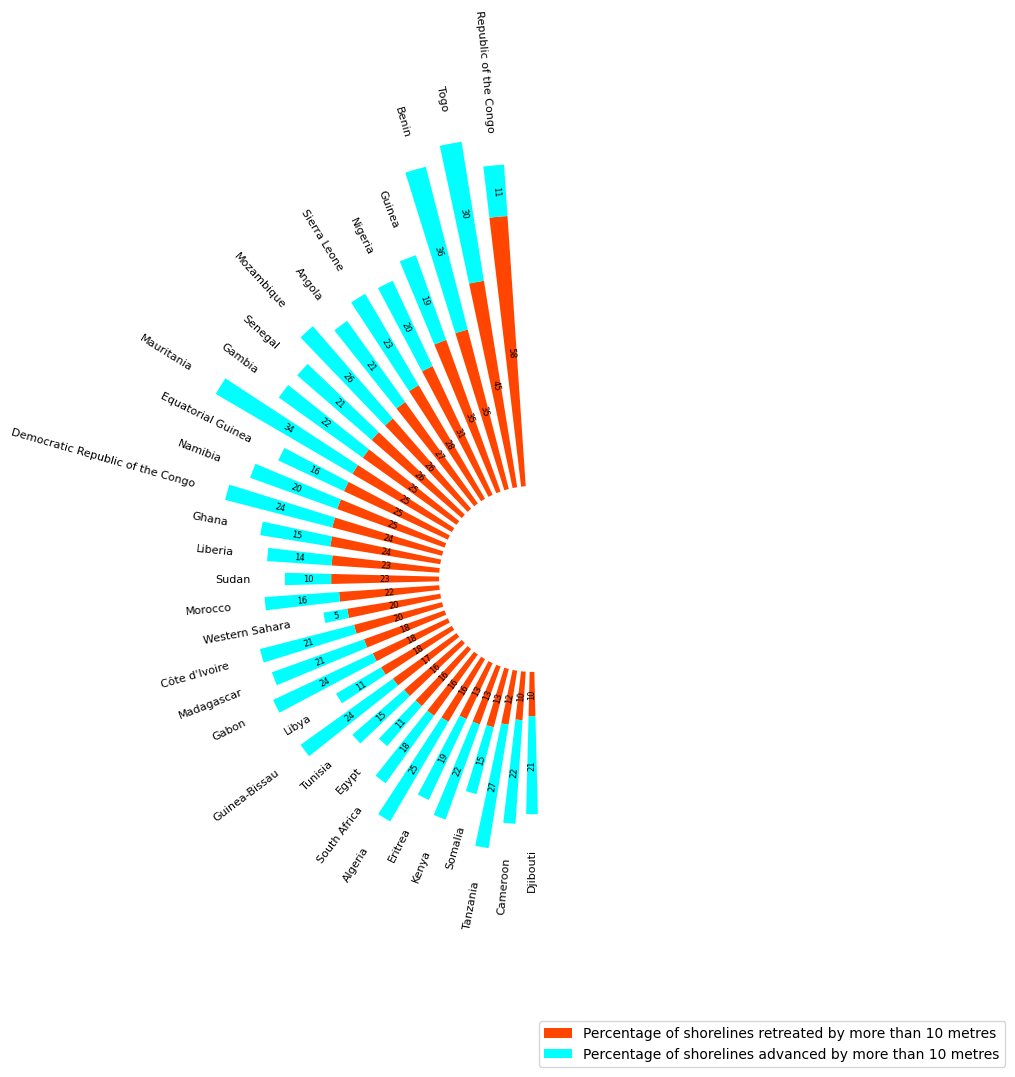

In [207]:
countries_sorted = countries_summary.sort_values(by='perc_negsm10')


countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.perc_negsm10)
pos_data = list(countries_sorted.perc_possm10)

# Set the color scheme for the segments
colors = ['orangered', 'cyan', 'grey']

# Calculate the angle for each bar
angles = np.linspace(0, np.pi, len(countries), endpoint=False)

# Create a polar plot
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, polar=True)

base= 20 #[np.max(neg_data)/2]*len(neg_data)
w=0.05
# Plot the red segments
ax.bar(angles, base, width=w, color='white')
neg_bars = ax.bar(angles, neg_data, width=w, bottom=base, color=colors[0], label='Percentage of shorelines retreated by more than 10 metres')
# Plot the white segments on top of the red segments
pos_bars = ax.bar(angles, pos_data, width=w, bottom=np.add(base, neg_data), color=colors[1], label='Percentage of shorelines advanced by more than 10 metres')
# Plot the blue segments on top of the red and white segments
#ax.bar(angles, blue_data, width=0.5, bottom=np.add(red_data, white_data), color=colors[2], label='Blue')

# Set the starting angle at the top (North)
ax.set_theta_zero_location("S")

# Set the clockwise direction for the bars
ax.set_theta_direction(-1)

# Set the tick labels
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0.5, 0.), ncol=1)

# Add country labels radially
for angle, country, label_radius in zip(angles, countries, np.add(np.add(np.add(neg_data, pos_data), base), np.max(neg_data)/8)):
    ax.text(angle, label_radius, country, ha='right', va='center', fontsize=8,
            rotation=270,#np.degrees(angle), 
            rotation_mode='anchor', transform_rotates_text=True)

# Add data value text to the center of each colored bar segment
for bars in [neg_bars, pos_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + bar.get_height() / 2
        ax.text(x_center, y_center, str(round(h)), ha='center', va='center', fontsize=6, 
                color='black', rotation=270, rotation_mode='anchor', transform_rotates_text=True)

        
fig.savefig('countries_sm_perc_polar_360.png',bbox_inches='tight')

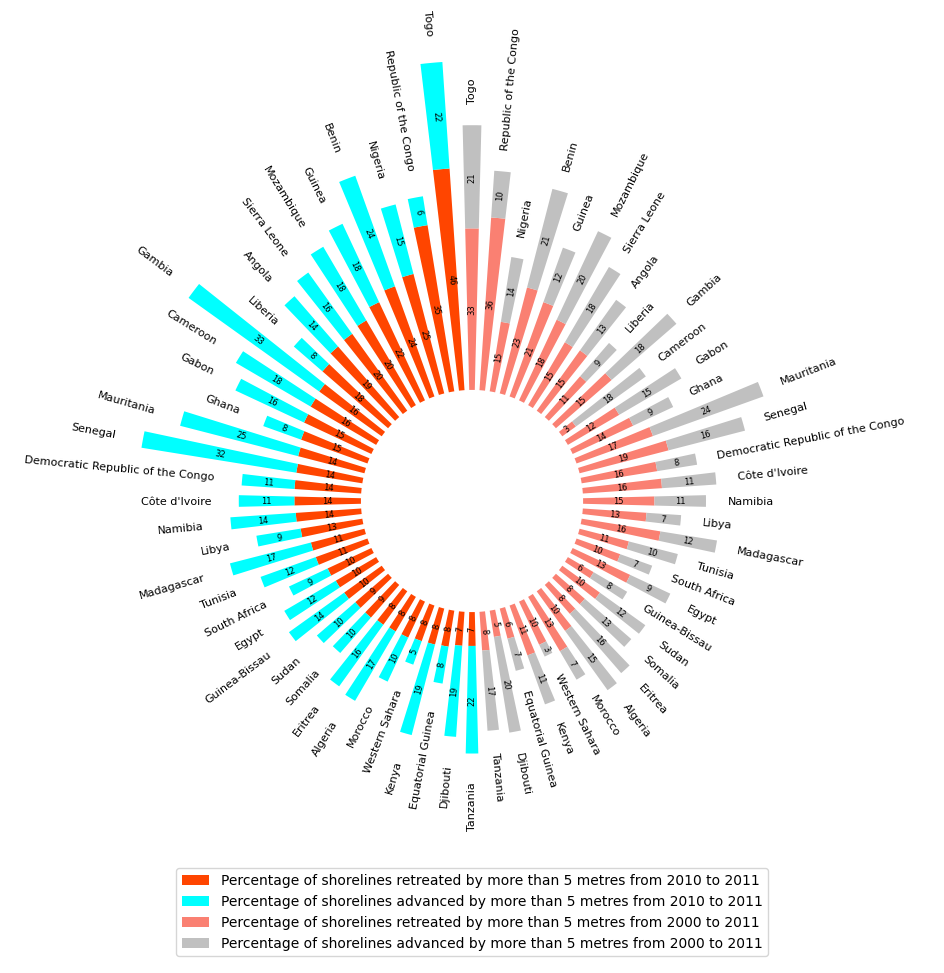

In [131]:
countries_sorted = countries_summary.sort_values(by='perc_negsm5_2010_2021')

countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.perc_negsm5_2010_2021)
pos_data = list(countries_sorted.perc_possm5_2010_2021)

# Set the color scheme for the segments
colors = ['orangered', 'aqua', 'grey']

# Calculate the angle for each bar
angles = np.linspace(0, np.pi, len(countries), endpoint=False)

# Create a polar plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, polar=True)

base=[np.max(neg_data)/2]*len(neg_data)
w=0.05
# Plot the red segments
ax.bar(angles, base, width=w, color='white')
neg_bars = ax.bar(angles, neg_data, width=w, bottom=base, color=colors[0], label='Percentage of shorelines retreated by more than 5 metres from 2010 to 2011')
# Plot the white segments on top of the red segments
pos_bars = ax.bar(angles, pos_data, width=w, bottom=np.add(base, neg_data), color=colors[1], label='Percentage of shorelines advanced by more than 5 metres from 2010 to 2011')
# Plot the blue segments on top of the red and white segments
#ax.bar(angles, blue_data, width=0.5, bottom=np.add(red_data, white_data), color=colors[2], label='Blue')

# Set the starting angle at the top (North)
ax.set_theta_zero_location("S")

# Set the clockwise direction for the bars
ax.set_theta_direction(-1)

# Set the tick labels
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")

# Place the legend outside of the figure
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 0), ncol=1)

# Add country labels radially
for angle, country, label_radius in zip(angles, countries, np.add(np.add(np.add(neg_data, pos_data), base), np.max(neg_data)/8)):
    ax.text(angle, label_radius, country, ha='right', va='center', fontsize=8,
            rotation=270,#np.degrees(angle), 
            rotation_mode='anchor', transform_rotates_text=True)

    
# Add data value text to the center of each colored bar segment
for bars in [neg_bars, pos_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + bar.get_height() / 2
        ax.text(x_center, y_center, str(round(h)), ha='center', va='center', fontsize=6, 
                color='black', rotation=270, rotation_mode='anchor', transform_rotates_text=True)


countries = list(countries_sorted.Country)[::-1]
neg_data = list(countries_sorted.perc_negsm5_2000_2011)[::-1]
pos_data = list(countries_sorted.perc_possm5_2000_2011)[::-1]

# Set the color scheme for the segments
colors = ['salmon', 'silver', 'grey']

# Calculate the angle for each bar
angles = np.linspace(np.pi, 2*np.pi, len(countries), endpoint=False)

w=0.05
# Plot the red segments
ax.bar(angles, base, width=w, color='white')
neg_bars = ax.bar(angles, neg_data, width=w, bottom=base, color=colors[0], label='Percentage of shorelines retreated by more than 5 metres from 2000 to 2011')
# Plot the white segments on top of the red segments
pos_bars = ax.bar(angles, pos_data, width=w, bottom=np.add(base, neg_data), color=colors[1], label='Percentage of shorelines advanced by more than 5 metres from 2000 to 2011')
# Plot the blue segments on top of the red and white segments
#ax.bar(angles, blue_data, width=0.5, bottom=np.add(red_data, white_data), color=colors[2], label='Blue')


# Set the tick labels
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")

# Place the legend outside of the figure
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 0), ncol=1)

# Add country labels radially
for angle, country, label_radius in zip(angles, countries, np.add(np.add(np.add(neg_data, pos_data), base), np.max(neg_data)/8)):
    ax.text(angle, label_radius, country, ha='left', va='center', fontsize=8,
            rotation=90,#np.degrees(angle), 
            rotation_mode='anchor', transform_rotates_text=True)

    
# Add data value text to the center of each colored bar segment
for bars in [neg_bars, pos_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + bar.get_height() / 2
        ax.text(x_center, y_center, str(round(h)), ha='center', va='center', fontsize=6, 
                color='black', rotation=90, rotation_mode='anchor', transform_rotates_text=True)

fig.savefig('countries_sm_perc_polar_2_periods_significant.png',bbox_inches='tight')